<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# **Capstone Project** 
# **Real-Time Facial Emotion Recognition - Notebook 2**

## Background

## Problem Statement

To create a model that can **accurately distinguish emotions based on facial expressions**.

The models are evaluated based on the following criteria:

1. Accuracy scores (the higher, the better)
2. Delta between train and test scores (the smaller, the better)

## Structure & Workflow

To organise my work better, I have organised this project into two notebooks, across six parts: 

**Notebook 1:** 
* Part 1 : Data Import
* Part 2: Exploratory Data Analysis

**Notebook 2:**
* Part 3: Data Preprocessing
* Part 4: Baseline Model: A CNN model built from scratch
* Part 5: Transfer Learning & Model Evaluation

**Notebook 3:**
* Part 6: Model Deployment

In [46]:
# import required libraries/packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import PIL
from PIL import Image
from zipfile import ZipFile
import cv2

from sklearn.decomposition import PCA
from math import ceil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay

pd.set_option('display.max_colwidth', 500)

## **3. Data Preprocessing**

* We will load a zip folder which contains a copy of the FER2013 dataset with only 5 emotion classes (without disgust and neutral). 

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
with ZipFile('/content/drive/MyDrive/data/fer2013 - Copy.zip','r') as zipObj:
  zipObj.extractall('/data')

path = '/data/fer2013 - Copy/'

In [49]:
train_path = '/data/fer2013 - Copy/train/'
test_path = '/data/fer2013 - Copy/test/'



### **Model Prep: Train-val-test split** 




* We want to have a holdout set to test our model. Therefore, we have applied the train_test_split function to split our original train set into a training set and a validation set.
* We will use 80% of the images for training and 20% for validation.


In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  labels='inferred', # labels are generated from the directory structure
  label_mode='int', # to encode the labels as integers
  seed=123, # to ensure reproducibility 
  image_size=(48, 48),
  batch_size=32, # default
  shuffle=True, 
  validation_split = 0.2, # 80/20 train/val split
  subset = 'training'
  )

Found 23308 files belonging to 5 classes.
Using 18647 files for training.


In [51]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(48, 48),
  batch_size=32,
  shuffle=True,
  validation_split = 0.2,
  subset = 'validation'
  )

Found 23308 files belonging to 5 classes.
Using 4661 files for validation.


In [52]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(48, 48),
  batch_size=32,
  shuffle=True,
  )

Found 5834 files belonging to 5 classes.


In [53]:
# to print the class names which correspond to the directory names in alphabetical order

class_names = train_ds.class_names
class_names

['angry', 'fear', 'happy', 'sad', 'surprise']

In [54]:
# print the shape of each image batch size

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 48, 48, 3)
(32,)


### **Model Prep: Data Augmentation**

In [55]:
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2)
])

### **Model Prep: Data Autotune**

* We will configure the dataset for performance by using buffered prefetching so we can yield data from disk without having I/O become blocking. 
* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model.
* Dataset.prefetch overlaps data preprocessing and model execution while training.

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Summary of Model Results

| Model | Train Accuracy | Val Accuracy | Delta | Test Accuracy | Evaluation|
| :-: | :-: | :-: | :-:|:-:|:-:|
| Baseline - Custom CNN Model | 0.5796| 0.5792|(0.0004)| 0.5817| Baseline|
| ResNet50 Model (Finetuned all layers) |0.9219| 0.6492|(0.2727)| 0.6530| 4th|
| MobileNetV2 Model (Finetuned all layers) |0.8247| 0.6857|(0.1390)| 0.6823| 2nd|
| VGG16 Model (Finetuned all layers) |0.9971| 0.6930|(0.3041)| 0.6808| 3rd|
| VGGFace Model (Finetuned all layers) |0.9786| 0.7629|(0.2157)| 0.7494| 1st|

## **4. Baseline Model: Custom CNN Model**

In [12]:
# build a custom CNN model with 4 convolutional layers and 2 fully connected layers

model5 = tf.keras.Sequential()

# convolutional layers
model5.add(tf.keras.Input(shape=(48, 48, 3), name='input_layer'))

model5.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu',name='conv_layer_1'))
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),name='pool_layer_1'))
model5.add(tf.keras.layers.Dropout(0.4))

model5.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu',name='conv_layer_2'))
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),name='pool_layer_2'))
model5.add(tf.keras.layers.Dropout(0.4))

model5.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu',name='conv_layer_3'))
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),name='pool_layer_3'))
model5.add(tf.keras.layers.Dropout(0.4))

model5.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu',name='conv_layer_4'))
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),name='pool_layer_4'))
model5.add(tf.keras.layers.Dropout(0.4))

model5.add(tf.keras.layers.Flatten())

# fully connected layers
model5.add(tf.keras.layers.Dense(512, activation='relu'))
model5.add(tf.keras.layers.Dropout(0.4))
model5.add(tf.keras.layers.Dense(256, activation='relu'))
model5.add(tf.keras.layers.Dropout(0.3))

# output layer
model5.add(tf.keras.layers.Dense(5, activation='softmax'))

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer_1 (Conv2D)       (None, 46, 46, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 128)      512       
 ormalization)                                                   
                                                                 
 pool_layer_1 (MaxPooling2D)  (None, 23, 23, 128)      0         
                                                                 
 dropout (Dropout)           (None, 23, 23, 128)       0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 21, 21, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 256)      1024      
 hNormalization)                                      

In [13]:
# Create a callback that saves the model's weights at each epoch

checkpoint_path_5 = "/content/drive/MyDrive/saved_models/model_5/model5-custom-bestmodel.hdf5"

cp_callback_5 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_5,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)

lrd_5 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.25,
                                        min_lr = 1e-10,
                                        verbose = 1)

es_5 = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                       patience=5,
                                       restore_best_weights=True) #no of epochs to run before stopping if there's no improvement in val_accuracy

callbacks_list_5 = [cp_callback_5]

In [14]:
history = dict()

base_learning_rate = 0.00146

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='sparse_categorical_crossentropy', metrics='accuracy') #model compiling before training

initial_epochs = 10

history['model5_custom'] =  model5.fit(train_ds, 
                                  validation_data=val_ds, 
                                  epochs=initial_epochs, 
                                  verbose=1,
                                  callbacks=[cp_callback_5])

Epoch 1/10
582/583 [============================>.] - ETA: 0s - loss: 1.5993 - accuracy: 0.3165
Epoch 1: val_accuracy improved from -inf to 0.36087, saving model to /content/drive/MyDrive/saved_models/model_5/model5-custom-bestmodel.hdf5
583/583 [==============================] - 21s 23ms/step - loss: 1.5990 - accuracy: 0.3167 - val_loss: 1.4644 - val_accuracy: 0.3609
Epoch 2/10
583/583 [==============================] - ETA: 0s - loss: 1.3880 - accuracy: 0.4118
Epoch 2: val_accuracy improved from 0.36087 to 0.45741, saving model to /content/drive/MyDrive/saved_models/model_5/model5-custom-bestmodel.hdf5
583/583 [==============================] - 12s 20ms/step - loss: 1.3880 - accuracy: 0.4118 - val_loss: 1.2997 - val_accuracy: 0.4574
Epoch 3/10
583/583 [==============================] - ETA: 0s - loss: 1.2923 - accuracy: 0.4491
Epoch 3: val_accuracy improved from 0.45741 to 0.47007, saving model to /content/drive/MyDrive/saved_models/model_5/model5-custom-bestmodel.hdf5
583/583 [=====

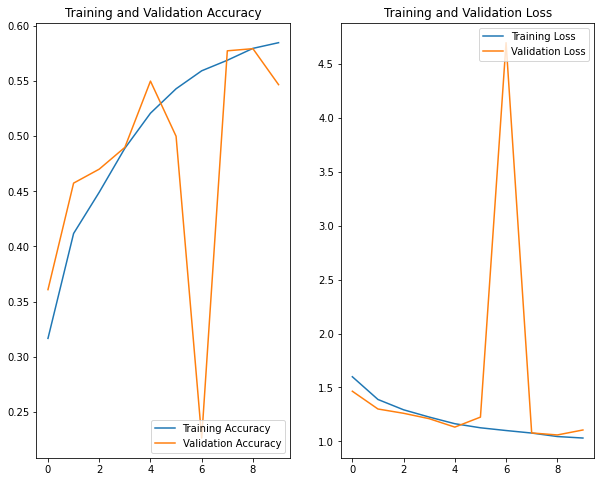

In [15]:
acc_model5 = history['model5_custom'].history['accuracy']
val_acc_model5 = history['model5_custom'].history['val_accuracy']

loss_model5 = history['model5_custom'].history['loss']
val_loss_model5 = history['model5_custom'].history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_model5, label='Training Accuracy')
plt.plot(epochs_range, val_acc_model5, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_model5, label='Training Loss')
plt.plot(epochs_range, val_loss_model5, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
baseline_model = tf.keras.models.load_model("/content/drive/MyDrive/saved_models/model_5/model5-custom-bestmodel.hdf5")

In [17]:
loss, accuracy = baseline_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

183/183 [==============================] - 2s 8ms/step - loss: 1.0529 - accuracy: 0.5818
Test accuracy : 0.5817620754241943


## **5.1 Transfer Learning #1: ResNet50 Base Model**

* RestNet50 is a convolutional neutral network with 50 layers. 
* The pre-trained network can classify images into 1000 object categories. 
* It is often used in transfer learning tasks related to image classification, object localization and segmentation. 

## **5.1.1 Use pre-trained ResNet50 as base model**

In [18]:
## Instantiate the Base Model based on RESNET50 architecture; default weights from 'imagenet'

base_model_resnet50 = ResNet50(include_top=False,
                      input_shape=(48, 48, 3),
                      weights='imagenet')

## Freeze the base_model
base_model_resnet50.trainable = False 

## Print model summary
base_model_resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [19]:
# Build a model by chaining together base model, two additional dense layers and prediction layer
# we will exclude the data augmentation layer for this run, but this can be re-run later
# previous trials show that the data augmentation layer will reduce the accuracy of the model 
# this is expected bc data augmentation introduces noise to the dataset

layer_1 = tf.keras.layers.Dense(128,activation='relu')
layer_2 = tf.keras.layers.Dense(56,activation='relu')

# output/prediction layer set to 5 since there are 5 emotion classes that we want to predict
prediction_layer = tf.keras.layers.Dense(5,activation='softmax') 

inputs = tf.keras.Input(shape=(48, 48, 3))
#x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model_resnet50(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layer_1(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layer_2(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model1_resnet50 = tf.keras.Model(inputs, outputs)
model1_resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 48, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0     

In [20]:
# Create a callback that saves the model's weights at each epoch

checkpoint_path_1 = "/content/drive/MyDrive/saved_models/model_1/model1_resnet50_bestmodel.hdf5"


cp_callback_1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)

In [21]:
# compile and fit the model over first 10 epochs 

history = dict()

model1_resnet50.compile(optimizer=Adam(learning_rate=0.00146),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

initial_epochs = 10

history['model1_resnet50'] = model1_resnet50.fit(train_ds, validation_data=val_ds, epochs=initial_epochs,verbose=1,callbacks=[cp_callback_1])

Epoch 1/10
580/583 [============================>.] - ETA: 0s - loss: 1.4987 - accuracy: 0.3769
Epoch 1: val_accuracy improved from -inf to 0.44454, saving model to /content/drive/MyDrive/saved_models/model_1/model1_resnet50_bestmodel.hdf5
583/583 [==============================] - 18s 24ms/step - loss: 1.4982 - accuracy: 0.3769 - val_loss: 1.3590 - val_accuracy: 0.4445
Epoch 2/10
580/583 [============================>.] - ETA: 0s - loss: 1.3644 - accuracy: 0.4323
Epoch 2: val_accuracy improved from 0.44454 to 0.46385, saving model to /content/drive/MyDrive/saved_models/model_1/model1_resnet50_bestmodel.hdf5
583/583 [==============================] - 12s 20ms/step - loss: 1.3645 - accuracy: 0.4320 - val_loss: 1.3085 - val_accuracy: 0.4638
Epoch 3/10
582/583 [============================>.] - ETA: 0s - loss: 1.3290 - accuracy: 0.4494
Epoch 3: val_accuracy improved from 0.46385 to 0.47329, saving model to /content/drive/MyDrive/saved_models/model_1/model1_resnet50_bestmodel.hdf5
583/583 

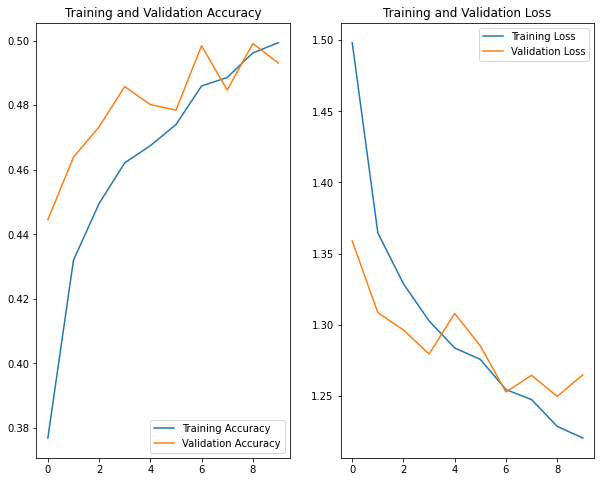

<Figure size 432x288 with 0 Axes>

In [22]:
# to plot the train/val accuracy and loss charts

acc_model1 = history['model1_resnet50'].history['accuracy']
val_acc_model1 = history['model1_resnet50'].history['val_accuracy']

loss_model1 = history['model1_resnet50'].history['loss']
val_loss_model1 = history['model1_resnet50'].history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_model1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_model1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_model1, label='Training Loss')
plt.plot(epochs_range, val_loss_model1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.tight_layout()

## **5.1.2 Fine-tuning Resnet50 Model**

In [23]:
base_model_resnet50.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_resnet50.layers))


Number of layers in the base model:  175


**Note:**
* Option to freeze the last convolutional layer can be taken below.
* I found that freezing x layers will reduce the accuracy of the model, which makes sense as pre-trained weights will be used instead of adjusting all the weights according to our unique dataset. 
* I decided to unfreeze ALL layers instead, because the ResNet50 model is used on classifying a large number of different classes which are not really related to emotions. 

In [24]:
# Fine-tune from this layer onwards
#fine_tune_at = 143 # last convolutional layer

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model_resnet50.layers[:fine_tune_at]:
#    layer.trainable = False

# Make sure we have frozen the correct layers
#for i, layer in enumerate(base_model_resnet50.layers):
#    print(i, layer.name, layer.trainable)

In [25]:
model1_resnet50.compile(optimizer=Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model1_resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 48, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0     

In [26]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

# save the best finetuned model

checkpoint_path_1 = "/content/drive/MyDrive/saved_models/model_1/model1_resnet50_finetuned_bestmodel.hdf5"

cp_callback_1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)


lrd_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.25,
                                        min_lr = 1e-10,
                                        verbose = 1)

es_1 = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                       patience=5, # no of epochs to run before stopping if there's no improvement in val_accuracy
                                       restore_best_weights=True) 

history['model1_resnet50_tuned'] = model1_resnet50.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history['model1_resnet50'].epoch[-1]+1,
                         callbacks=[cp_callback_1,lrd_1,es_1],
                         validation_data=val_ds,verbose=1)

Epoch 11/50
583/583 [==============================] - ETA: 0s - loss: 1.1517 - accuracy: 0.5315
Epoch 11: val_accuracy improved from -inf to 0.56576, saving model to /content/drive/MyDrive/saved_models/model_1/model1_resnet50_finetuned_bestmodel.hdf5
583/583 [==============================] - 38s 55ms/step - loss: 1.1517 - accuracy: 0.5315 - val_loss: 1.0841 - val_accuracy: 0.5658 - lr: 1.0000e-05
Epoch 12/50
582/583 [============================>.] - ETA: 0s - loss: 0.9984 - accuracy: 0.5934
Epoch 12: val_accuracy improved from 0.56576 to 0.58678, saving model to /content/drive/MyDrive/saved_models/model_1/model1_resnet50_finetuned_bestmodel.hdf5
583/583 [==============================] - 33s 56ms/step - loss: 0.9984 - accuracy: 0.5934 - val_loss: 1.0308 - val_accuracy: 0.5868 - lr: 1.0000e-05
Epoch 13/50
582/583 [============================>.] - ETA: 0s - loss: 0.8772 - accuracy: 0.6362
Epoch 13: val_accuracy improved from 0.58678 to 0.60416, saving model to /content/drive/MyDrive/

In [27]:
acc_model1 += history['model1_resnet50_tuned'].history['accuracy']
val_acc_model1 += history['model1_resnet50_tuned'].history['val_accuracy']

loss_model1 += history['model1_resnet50_tuned'].history['loss']
val_loss_model1 += history['model1_resnet50_tuned'].history['val_loss']

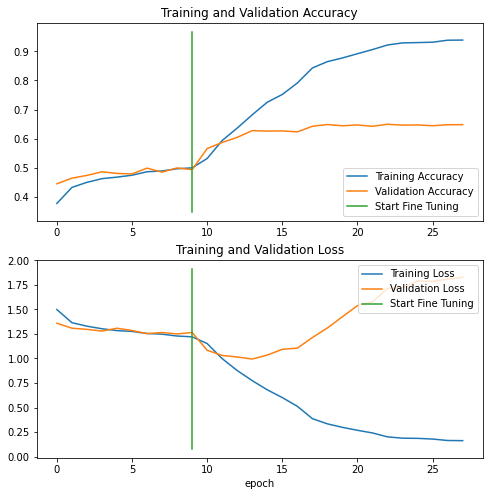

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_model1, label='Training Accuracy')
plt.plot(val_acc_model1, label='Validation Accuracy')
#plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_model1, label='Training Loss')
plt.plot(val_loss_model1, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.tight_layout()

## **5.1.3 Fine-tuned ResNet50 Model: Evaluate on Test Set**

In [29]:
best_resnet50_model = tf.keras.models.load_model("/content/drive/MyDrive/saved_models/model_1/model1_resnet50_finetuned_bestmodel.hdf5")

In [30]:
loss, accuracy = best_resnet50_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

183/183 [==============================] - 4s 18ms/step - loss: 1.6899 - accuracy: 0.6531
Test accuracy : 0.6530682444572449


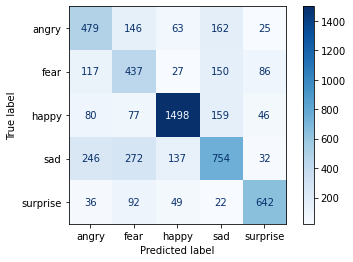

In [31]:
# evaluating test dataset

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = best_resnet50_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm_test = confusion_matrix(predicted_labels,correct_labels)

labels = ['angry', 'fear', 'happy', 'sad', 'surprise']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [32]:
print(classification_report(correct_labels, predicted_labels,target_names=labels))

              precision    recall  f1-score   support

       angry       0.55      0.50      0.52       958
        fear       0.53      0.43      0.47      1024
       happy       0.81      0.84      0.82      1774
         sad       0.52      0.60      0.56      1247
    surprise       0.76      0.77      0.77       831

    accuracy                           0.65      5834
   macro avg       0.63      0.63      0.63      5834
weighted avg       0.65      0.65      0.65      5834



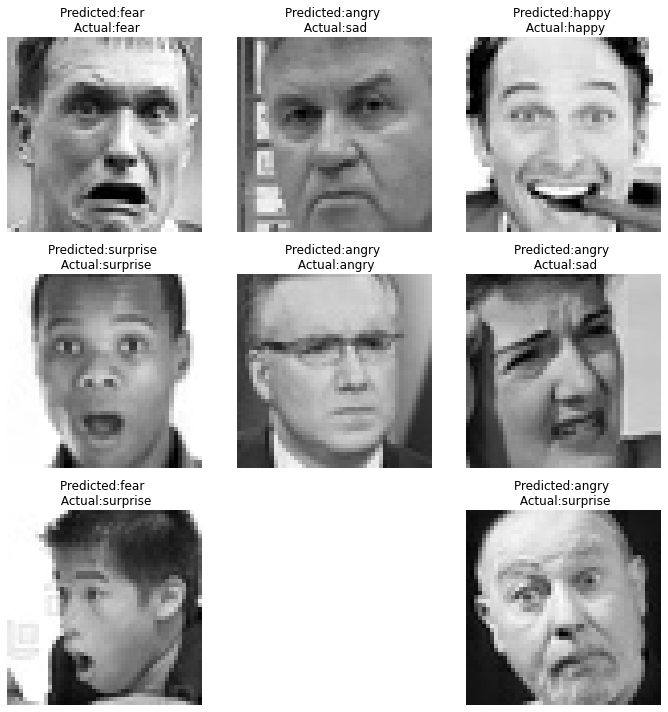

In [33]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = best_resnet50_model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("Predicted:{} \n Actual:{}".format(class_names[predictions[i]],class_names[label_batch[i]]))
  plt.axis("off")
  plt.tight_layout()

## **5.2 Transfer Learning #2: MobileNetV2 Base Model**

* MobileNetV2 is a convolutional neural network architecture that performs well on mobile devides.
* It is based on an inverted residual structure where the residual connections are between the bottleneck layers. 

## **5.2.1 Use pre-trained MobileNetV2 as base model**

In [34]:
# Create the base model from the pre-trained model MobileNet V2
mobilenetv2_base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze base model
mobilenetv2_base_model.trainable = False

#print base model summary
mobilenetv2_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [35]:
# Build a model by chaining together base model, several additional layers and prediction layer
# We have also included a resizing layer bc this model requires the input to be 224*224 at least.
# We will exclude the data augmentation layer for this run, but this can be re-run later
# Previous trials show that the data augmentation layer will reduce the accuracy of the model 
# This is expected bc data augmentation introduces noise to the dataset

resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
layer_1 = tf.keras.layers.Dense(128, activation='relu') #128
layer_2 = tf.keras.layers.Dense(64,activation='relu')
layer_3 = tf.keras.layers.Dense(28,activation='relu')
prediction_layer = tf.keras.layers.Dense(5,activation='softmax')

inputs = tf.keras.Input(shape=(48, 48, 3))
#x = data_augmentation(inputs)
x = resizing_layer(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = mobilenetv2_base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layer_1(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layer_2(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layer_3(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model2_mobilenetv2 = tf.keras.Model(inputs, outputs)
model2_mobilenetv2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [36]:
# Create a callback that saves the model's weights at each epoch

checkpoint_path_2 = "/content/drive/MyDrive/saved_models/model_2/model2_mobilenetv2_bestmodel.hdf5"

cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)

In [37]:
# compile and fit the model over first 10 epochs 

history = dict()

base_learning_rate = 0.00146 #10E-6 #0.001 #0.00146 

model2_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10

history['model2_mobilenetv2'] =  model2_mobilenetv2.fit(train_ds, 
                                  validation_data=val_ds, 
                                  epochs=initial_epochs, 
                                  verbose=1,callbacks=[cp_callback_2])

Epoch 1/10
583/583 [==============================] - ETA: 0s - loss: 1.4253 - accuracy: 0.3920
Epoch 1: val_accuracy improved from -inf to 0.46750, saving model to /content/drive/MyDrive/saved_models/model_2/model2_mobilenetv2_bestmodel-01.hdf5
583/583 [==============================] - 32s 50ms/step - loss: 1.4253 - accuracy: 0.3920 - val_loss: 1.3371 - val_accuracy: 0.4675
Epoch 2/10
583/583 [==============================] - ETA: 0s - loss: 1.2978 - accuracy: 0.4604
Epoch 2: val_accuracy improved from 0.46750 to 0.51212, saving model to /content/drive/MyDrive/saved_models/model_2/model2_mobilenetv2_bestmodel-02.hdf5
583/583 [==============================] - 28s 48ms/step - loss: 1.2978 - accuracy: 0.4604 - val_loss: 1.2309 - val_accuracy: 0.5121
Epoch 3/10
583/583 [==============================] - ETA: 0s - loss: 1.2487 - accuracy: 0.4815
Epoch 3: val_accuracy improved from 0.51212 to 0.51577, saving model to /content/drive/MyDrive/saved_models/model_2/model2_mobilenetv2_bestmode

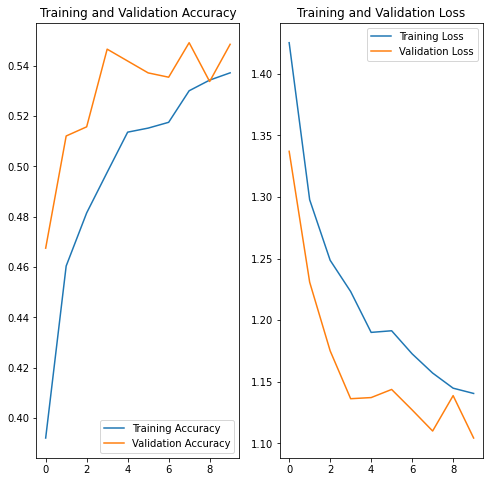

In [38]:
# to plot the train/val accuracy and loss charts

acc_model2 = history['model2_mobilenetv2'].history['accuracy']
val_acc_model2 = history['model2_mobilenetv2'].history['val_accuracy']

loss_model2 = history['model2_mobilenetv2'].history['loss']
val_loss_model2 = history['model2_mobilenetv2'].history['val_loss']

epochs_range = range(10) #50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_model2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_model2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_model2, label='Training Loss')
plt.plot(epochs_range, val_loss_model2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **5.2.2 Fine-tuning MobileNetV2 Model**

In [39]:
mobilenetv2_base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenetv2_base_model.layers))


Number of layers in the base model:  154


**Note:**
* Option to freeze the last convolutional layer can be taken below.
* I found that freezing x layers will reduce the accuracy of the model, which makes sense as pre-trained weights will be used instead of adjusting all the weights according to our unique dataset. 
* I decided to unfreeze ALL layers instead, because the MobileNetV2 model is used on classifying objects and locations which is it exactly the same as the objective of my project i.e. classifying emotions.

In [40]:
# Fine-tune from this layer onwards
# fine_tune_at = 125 # last 3 blocks

# Freeze all the layers before the `fine_tune_at` layer
# for layer in mobilenetv2_base_model.layers[:fine_tune_at]:
#    layer.trainable = False

# Make sure you have frozen the correct layers
# for i, layer in enumerate(mobilenetv2_base_model.layers):
#    print(i, layer.name, layer.trainable)

In [41]:
model2_mobilenetv2.compile(optimizer=Adam(learning_rate=base_learning_rate*0.1),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model2_mobilenetv2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [42]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

# Create a callback that saves the best finetuned model

checkpoint_path_2 = "/content/drive/MyDrive/saved_models/model_2/model2_mobilenetv2_finetuned_bestmodel.hdf5"

cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)

lrd_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 3,
                                        factor = 0.25,                                   
                                        verbose = 1,
                                        min_lr = 1e-7) #1e-10 #1e-7

es_2 = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                       patience=5,
                                       restore_best_weights=True) #no of epochs to run before stopping if there's no improvement in val_accuracy

history['model2_mobilenetv2_tuned'] = model2_mobilenetv2.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history['model2_mobilenetv2'].epoch[-1]+1,
                         callbacks=[cp_callback_2,lrd_2,es_2],
                         validation_data=val_ds,
                         verbose=1)

Epoch 11/50
583/583 [==============================] - ETA: 0s - loss: 1.5848 - accuracy: 0.3041
Epoch 11: val_accuracy improved from -inf to 0.30294, saving model to /content/drive/MyDrive/saved_models/model_2/model2_mobilenetv2_finetuned_bestmodel.hdf5
583/583 [==============================] - 147s 243ms/step - loss: 1.5848 - accuracy: 0.3041 - val_loss: 1.5764 - val_accuracy: 0.3029 - lr: 1.4600e-04
Epoch 12/50
583/583 [==============================] - ETA: 0s - loss: 1.4980 - accuracy: 0.3444
Epoch 12: val_accuracy improved from 0.30294 to 0.39047, saving model to /content/drive/MyDrive/saved_models/model_2/model2_mobilenetv2_finetuned_bestmodel.hdf5
583/583 [==============================] - 141s 242ms/step - loss: 1.4980 - accuracy: 0.3444 - val_loss: 1.3814 - val_accuracy: 0.3905 - lr: 1.4600e-04
Epoch 13/50
583/583 [==============================] - ETA: 0s - loss: 1.2173 - accuracy: 0.4953
Epoch 13: val_accuracy improved from 0.39047 to 0.55503, saving model to /content/driv

In [43]:
acc_model2 += history['model2_mobilenetv2_tuned'].history['accuracy']
val_acc_model2 += history['model2_mobilenetv2_tuned'].history['val_accuracy']

loss_model2 += history['model2_mobilenetv2_tuned'].history['loss']
val_loss_model2 += history['model2_mobilenetv2_tuned'].history['val_loss']

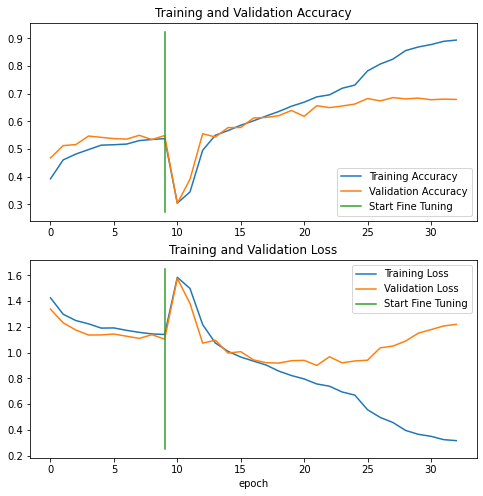

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_model2, label='Training Accuracy')
plt.plot(val_acc_model2, label='Validation Accuracy')
#plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_model2, label='Training Loss')
plt.plot(val_loss_model2, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.tight_layout()

## **5.2.3 Fine-tuned MobileNetV2 Model: Evaluate on Test Set**

In [58]:
best_mobilnetv2_model = tf.keras.models.load_model("/content/drive/MyDrive/saved_models/model_2/model2_mobilenetv2_finetuned_bestmodel.hdf5")

In [59]:
loss, accuracy = best_mobilnetv2_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

183/183 [==============================] - 8s 38ms/step - loss: 1.0676 - accuracy: 0.6824
Test accuracy : 0.6823791861534119


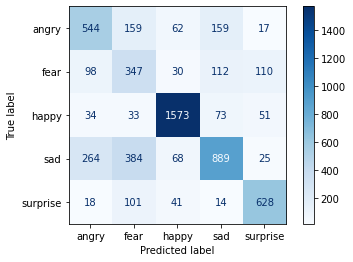

In [61]:
# evaluating test dataset

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = best_mobilnetv2_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm_test = confusion_matrix(predicted_labels,correct_labels)

labels = ['angry', 'fear', 'happy', 'sad', 'surprise']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [62]:
print(classification_report(correct_labels, predicted_labels,target_names=labels))

              precision    recall  f1-score   support

       angry       0.58      0.57      0.57       958
        fear       0.50      0.34      0.40      1024
       happy       0.89      0.89      0.89      1774
         sad       0.55      0.71      0.62      1247
    surprise       0.78      0.76      0.77       831

    accuracy                           0.68      5834
   macro avg       0.66      0.65      0.65      5834
weighted avg       0.68      0.68      0.68      5834



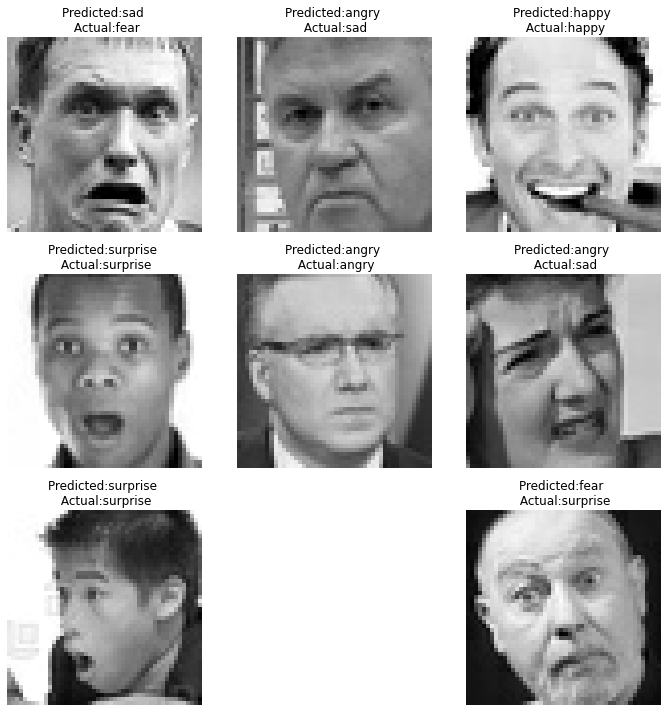

In [63]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = best_mobilnetv2_model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("Predicted:{} \n Actual:{}".format(class_names[predictions[i]],class_names[label_batch[i]]))
  plt.axis("off")
  plt.tight_layout()

## **5.3 Transfer Learning #3: VGG16 Base Model**

* VGG16 model is used for object detection and classification, with the ability to classify 1000 images of 1000 different categories with 92.7% accuracy.

## **5.3.1 Use pre-trained VGG16 as base model**

In [64]:
# Create the base model from the pre-trained model 
vgg16_base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
#                                               pooling='avg')

vgg16_base_model.trainable = False

vgg16_base_model.summary()

58900480/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [65]:
# Build a model by chaining together base model, several additional layers and prediction layer
# We have also included a resizing layer bc this model requires the input to be 224*224 at least.
# We will exclude the data augmentation layer for this run, but this can be re-run later
# Previous trials show that the data augmentation layer will reduce the accuracy of the model 
# This is expected bc data augmentation introduces noise to the dataset

resizing_layer = tf.keras.layers.Resizing(224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
layer_1 = tf.keras.layers.Dense(128, activation='relu')
layer_2 = tf.keras.layers.Dense(56,activation='relu')
layer_3 = tf.keras.layers.Dense(28,activation='relu')
prediction_layer = tf.keras.layers.Dense(5,activation='softmax')

inputs = tf.keras.Input(shape=(48, 48, 3))
x = resizing_layer(inputs)
# x = data_augmentation(x) 
x = tf.keras.applications.vgg16.preprocess_input(x)
x = vgg16_base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layer_1(x)
x = tf.keras.layers.Dropout(0.2)(x) 
x = layer_2(x)
x = tf.keras.layers.Dropout(0.2)(x) 
x = layer_3(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model3_vgg16 = tf.keras.Model(inputs, outputs)
model3_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0   

In [66]:
# Create a callback to save the best model

checkpoint_path_3 = "/content/drive/MyDrive/saved_models/model_3/model3-vgg16-bestmodel.hdf5"


cp_callback_3 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_3,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)

In [67]:
# compile and fit the model over first 10 epochs 

history = dict()

base_learning_rate = 0.00146

model3_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10

history['model3_vgg16'] =  model3_vgg16.fit(train_ds, 
                                  validation_data=val_ds, 
                                  epochs=initial_epochs, 
                                  verbose=1,callbacks=[cp_callback_3])

Epoch 1/10
583/583 [==============================] - ETA: 0s - loss: 1.5234 - accuracy: 0.3506
Epoch 1: val_accuracy improved from -inf to 0.48831, saving model to /content/drive/MyDrive/saved_models/model_3/model3-vgg16-bestmodel.hdf5
583/583 [==============================] - 123s 200ms/step - loss: 1.5234 - accuracy: 0.3506 - val_loss: 1.3015 - val_accuracy: 0.4883
Epoch 2/10
583/583 [==============================] - ETA: 0s - loss: 1.3537 - accuracy: 0.4349
Epoch 2: val_accuracy improved from 0.48831 to 0.48981, saving model to /content/drive/MyDrive/saved_models/model_3/model3-vgg16-bestmodel.hdf5
583/583 [==============================] - 113s 194ms/step - loss: 1.3537 - accuracy: 0.4349 - val_loss: 1.2892 - val_accuracy: 0.4898
Epoch 3/10
583/583 [==============================] - ETA: 0s - loss: 1.3029 - accuracy: 0.4588
Epoch 3: val_accuracy improved from 0.48981 to 0.51191, saving model to /content/drive/MyDrive/saved_models/model_3/model3-vgg16-bestmodel.hdf5
583/583 [====

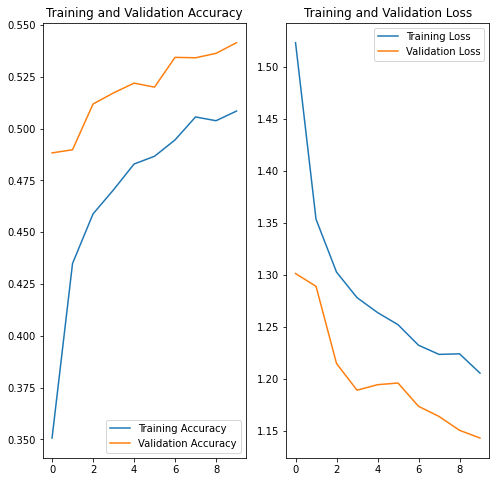

In [68]:
acc_model3 = history['model3_vgg16'].history['accuracy']
val_acc_model3 = history['model3_vgg16'].history['val_accuracy']

loss_model3 = history['model3_vgg16'].history['loss']
val_loss_model3 = history['model3_vgg16'].history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_model3, label='Training Accuracy')
plt.plot(epochs_range, val_acc_model3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_model3, label='Training Loss')
plt.plot(epochs_range, val_loss_model3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **5.3.2 Fine-tuning VGG16 Model**

In [69]:
vgg16_base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vgg16_base_model.layers))


Number of layers in the base model:  19


**Note:**
* Option to freeze the last convolutional layer can be taken below.
* I found that freezing x layers will reduce the accuracy of the model, which makes sense as pre-trained weights will be used instead of adjusting all the weights according to our unique dataset. 
* I decided to unfreeze ALL layers instead.

In [70]:
# Fine-tune from this layer onwards
fine_tune_at = 11

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16_base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg16_base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [71]:
base_learning_rate = 0.00146

model3_vgg16.compile(optimizer=Adam(learning_rate=base_learning_rate * 0.1),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model3_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0   

In [72]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

# save the best finetuned model

checkpoint_path_3 = "/content/drive/MyDrive/saved_models/model_3/model3_vgg16_finetuned_bestmodel.hdf5"

cp_callback_3 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_3,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)
lrd_3 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.25,
                                        min_lr = 1e-10, #1e-10
                                        verbose = 1)

es_3 = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                       patience=5,
                                       restore_best_weights=True) #no of epochs to run before stopping if there's no improvement in val_accuracy

history['model3_vgg16_tuned'] = model3_vgg16.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history['model3_vgg16'].epoch[-1]+1,
                         callbacks=[cp_callback_3,lrd_3,es_3],
                         validation_data=val_ds,verbose=1)

Epoch 11/50
583/583 [==============================] - ETA: 0s - loss: 1.4253 - accuracy: 0.3866
Epoch 11: val_accuracy improved from -inf to 0.51770, saving model to /content/drive/MyDrive/saved_models/model_3/model3_vgg16_finetuned_bestmodel.hdf5
583/583 [==============================] - 153s 260ms/step - loss: 1.4253 - accuracy: 0.3866 - val_loss: 1.2055 - val_accuracy: 0.5177 - lr: 1.4600e-04
Epoch 12/50
583/583 [==============================] - ETA: 0s - loss: 1.1675 - accuracy: 0.5182
Epoch 12: val_accuracy improved from 0.51770 to 0.55203, saving model to /content/drive/MyDrive/saved_models/model_3/model3_vgg16_finetuned_bestmodel.hdf5
583/583 [==============================] - 152s 261ms/step - loss: 1.1675 - accuracy: 0.5182 - val_loss: 1.1265 - val_accuracy: 0.5520 - lr: 1.4600e-04
Epoch 13/50
583/583 [==============================] - ETA: 0s - loss: 1.0657 - accuracy: 0.5564
Epoch 13: val_accuracy improved from 0.55203 to 0.56962, saving model to /content/drive/MyDrive/sa

In [78]:
acc_model3 += history['model3_vgg16_tuned'].history['accuracy']
val_acc_model3 += history['model3_vgg16_tuned'].history['val_accuracy']

loss_model3 += history['model3_vgg16_tuned'].history['loss']
val_loss_model3 += history['model3_vgg16_tuned'].history['val_loss']

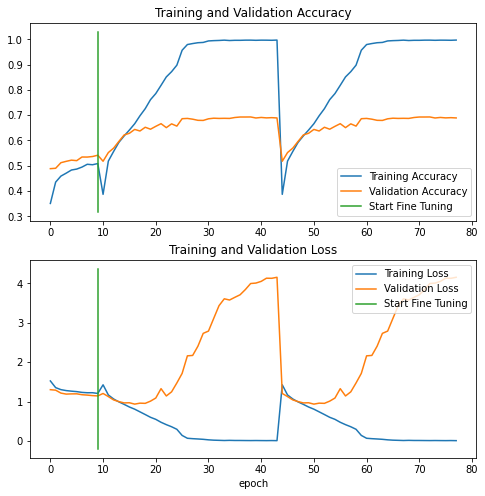

In [79]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_model3, label='Training Accuracy')
plt.plot(val_acc_model3, label='Validation Accuracy')
#plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_model3, label='Training Loss')
plt.plot(val_loss_model3, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **5.3.3 Fine-tuned VGG16 Model: Evaluate on Test Set**

In [80]:
best_vgg16_model = tf.keras.models.load_model("/content/drive/MyDrive/saved_models/model_3/model3_vgg16_finetuned_bestmodel.hdf5")

In [81]:
loss, accuracy = best_vgg16_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

183/183 [==============================] - 28s 153ms/step - loss: 3.8687 - accuracy: 0.6808
Test accuracy : 0.6808364987373352


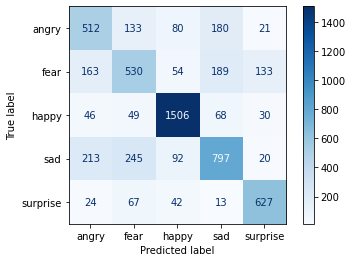

In [82]:
# evaluating test dataset

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = best_vgg16_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm_test = confusion_matrix(predicted_labels,correct_labels)

labels = ['angry', 'fear', 'happy', 'sad', 'surprise']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [83]:
print(classification_report(correct_labels, predicted_labels,target_names=labels))

              precision    recall  f1-score   support

       angry       0.55      0.53      0.54       958
        fear       0.50      0.52      0.51      1024
       happy       0.89      0.85      0.87      1774
         sad       0.58      0.64      0.61      1247
    surprise       0.81      0.75      0.78       831

    accuracy                           0.68      5834
   macro avg       0.67      0.66      0.66      5834
weighted avg       0.69      0.68      0.68      5834



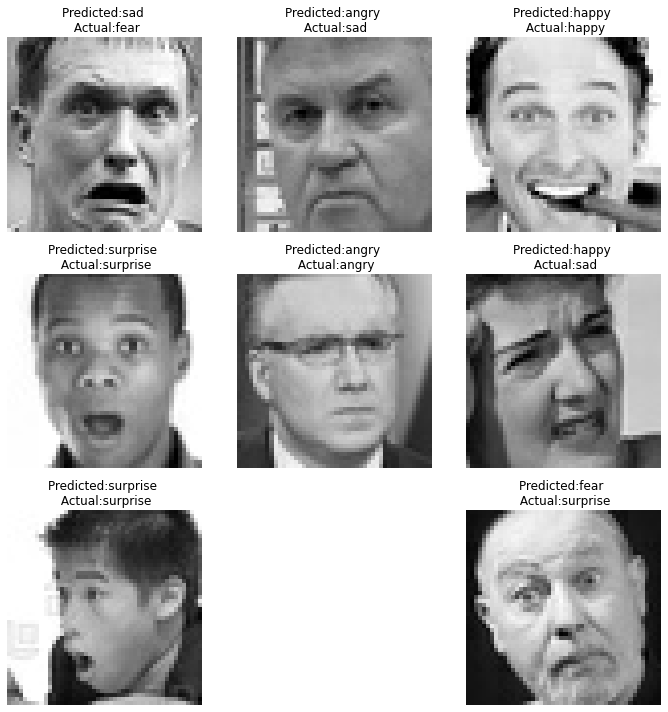

In [84]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = best_vgg16_model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("Predicted:{} \n Actual:{}".format(class_names[predictions[i]],class_names[label_batch[i]]))
  plt.axis("off")
  plt.tight_layout()

## **5.4 Transfer Learning #4: VGGFace Base Model**

* VGGFace is a model developed specifically for face recognition tasks such as face identification and verification. 
* The model is trained on two different datasets: ResNet-50 and SqueezeNet-ResNet-50 (SeNet). SeNet is a smaller network that can easily fit into computer memory and be easily transmitted over a computer network. In this trial, we will use the VGGFace model with weight derived from SeNet training.

## **5.4.1 Use pre-trained VGGFace as base model**

In [85]:
# Most Recent One 

!pip install git+https://github.com/rcmalli/keras-vggface.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-hg0r39i2
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-hg0r39i2
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=c5c17230c4254c26e173fb82b20af4c3d566750ff80dfa0da8ddfc52f147b9c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-vv7w6p_z/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [92]:
!pip install keras_applications --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
filename = r"/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace

vggface = VGGFace()

580083712/580070376 [==============================] - 3s 0us/step


In [94]:
## Instantiate the Base Model
vggface_base_model = VGGFace(include_top=False,
                           input_shape=(224, 224, 3),
                            model='senet50')

## Freeze the base_model
vggface_base_model.trainable = False
## Print model summary
vggface_base_model.summary()

104955904/104944616 [==============================] - 20s 0us/step
Model: "vggface_senet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)         

In [95]:
# Build a model by chaining together base model, several additional layers and prediction layer
# We have also included a resizing layer bc this model requires the input to be 224*224 at least.
# We will exclude the data augmentation layer for this run, but this can be re-run later
# Previous trials show that the data augmentation layer will reduce the accuracy of the model 
# This is expected bc data augmentation introduces noise to the dataset

resizing_layer = tf.keras.layers.Resizing(224, 224)
layer_1 = tf.keras.layers.Dense(128, activation='relu')
layer_2 = tf.keras.layers.Dense(56,activation='relu')
layer_3 = tf.keras.layers.Dense(28,activation='relu')
prediction_layer = tf.keras.layers.Dense(5,activation='softmax')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

inputs = tf.keras.Input(shape=(48, 48, 3))
x = resizing_layer(inputs)
# x = data_augmentation(x)
x = vggface_base_model(x, training=False)
x = global_average_layer(x)
x = layer_1(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layer_2(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layer_3(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model4_vggface = tf.keras.Model(inputs, outputs)
model4_vggface.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 vggface_senet50 (Functional  (None, 1, 1, 2048)       26092144  
 )                                                               
                                                                 
 global_average_pooling2d_19  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 128)               262272    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0   

In [96]:
# Create a callback that saves the best model

checkpoint_path_4 = "/content/drive/MyDrive/saved_models/model_4/model4-vgface-bestmodel.hdf5"

cp_callback_4 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_4,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)

In [97]:
history = dict()

base_learning_rate = 0.00146

model4_vggface.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10
history['model4_vggface'] =  model4_vggface.fit(train_ds, 
                                  validation_data=val_ds, 
                                  epochs=initial_epochs, 
                                  verbose=1,callbacks=[cp_callback_4])

Epoch 1/10
583/583 [==============================] - ETA: 0s - loss: 1.4379 - accuracy: 0.4122
Epoch 1: val_accuracy improved from -inf to 0.56147, saving model to /content/drive/MyDrive/saved_models/model_4/model4-vgface-bestmodel.hdf5
583/583 [==============================] - 79s 126ms/step - loss: 1.4379 - accuracy: 0.4122 - val_loss: 1.1542 - val_accuracy: 0.5615
Epoch 2/10
583/583 [==============================] - ETA: 0s - loss: 1.1565 - accuracy: 0.5407
Epoch 2: val_accuracy improved from 0.56147 to 0.58957, saving model to /content/drive/MyDrive/saved_models/model_4/model4-vgface-bestmodel.hdf5
583/583 [==============================] - 73s 125ms/step - loss: 1.1565 - accuracy: 0.5407 - val_loss: 1.0527 - val_accuracy: 0.5896
Epoch 3/10
583/583 [==============================] - ETA: 0s - loss: 1.0869 - accuracy: 0.5740
Epoch 3: val_accuracy did not improve from 0.58957
583/583 [==============================] - 72s 123ms/step - loss: 1.0869 - accuracy: 0.5740 - val_loss: 1.

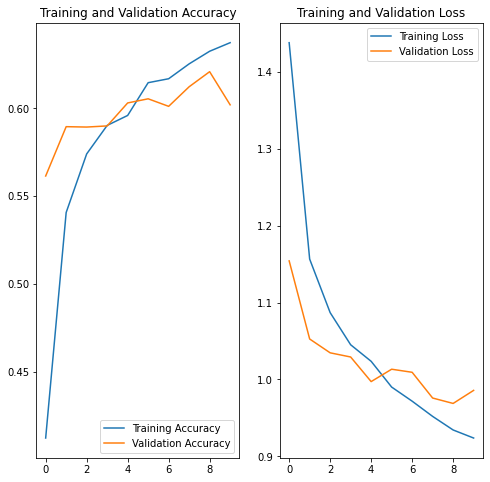

<Figure size 432x288 with 0 Axes>

In [98]:
acc_model4 = history['model4_vggface'].history['accuracy']
val_acc_model4 = history['model4_vggface'].history['val_accuracy']

loss_model4 = history['model4_vggface'].history['loss']
val_loss_model4 = history['model4_vggface'].history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_model4, label='Training Accuracy')
plt.plot(epochs_range, val_acc_model4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_model4, label='Training Loss')
plt.plot(epochs_range, val_loss_model4, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.tight_layout()

## **5.4.2 Fine-tuning VGGFace Model**

In [99]:
vggface_base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vggface_base_model.layers))


Number of layers in the base model:  286


**Note:**
* Option to freeze the last convolutional layer can be taken below.
* I found that freezing x layers will reduce the accuracy of the model, which makes sense as pre-trained weights will be used instead of adjusting all the weights according to our unique dataset. 
* I decided to unfreeze ALL layers instead.

In [100]:
# Fine-tune from this layer onwards
#fine_tune_at = 230 

# Freeze all the layers before the `fine_tune_at` layer
#for layer in vggface_base_model.layers[:fine_tune_at]:
#    layer.trainable = False

# Make sure you have frozen the correct layers
#for i, layer in enumerate(vggface_base_model.layers):
#    print(i, layer.name, layer.trainable)

In [101]:
model4_vggface.compile(optimizer=Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model4_vggface.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 vggface_senet50 (Functional  (None, 1, 1, 2048)       26092144  
 )                                                               
                                                                 
 global_average_pooling2d_19  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 128)               262272    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0   

In [102]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

# save the best finetuned model

checkpoint_path_4 = "/content/drive/MyDrive/saved_models/model_4/model4_vggface_finetuned_bestmodel.hdf5"

cp_callback_4 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_4,
                                                   monitor = 'val_accuracy',
                                                 save_best_only=True,
                                                 verbose=1)

lrd_4 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.25,
                                        min_lr = 1e-10,
                                        verbose = 1)

es_4 = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                       patience=5,
                                       restore_best_weights=True) #no of epochs to run before stopping if there's no improvement in val_accuracy

history['model4_vggface_tuned'] = model4_vggface.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history['model4_vggface'].epoch[-1]+1,
                         callbacks=[cp_callback_4,lrd_4,es_4],
                         validation_data=val_ds,verbose=1)

Epoch 11/50
583/583 [==============================] - ETA: 0s - loss: 0.9409 - accuracy: 0.6388
Epoch 11: val_accuracy improved from -inf to 0.66188, saving model to /content/drive/MyDrive/saved_models/model_4/model4_vggface_finetuned_bestmodel.hdf5
583/583 [==============================] - 250s 415ms/step - loss: 0.9409 - accuracy: 0.6388 - val_loss: 0.8675 - val_accuracy: 0.6619 - lr: 1.0000e-05
Epoch 12/50
583/583 [==============================] - ETA: 0s - loss: 0.8098 - accuracy: 0.6854
Epoch 12: val_accuracy improved from 0.66188 to 0.69127, saving model to /content/drive/MyDrive/saved_models/model_4/model4_vggface_finetuned_bestmodel.hdf5
583/583 [==============================] - 241s 414ms/step - loss: 0.8098 - accuracy: 0.6854 - val_loss: 0.7883 - val_accuracy: 0.6913 - lr: 1.0000e-05
Epoch 13/50
583/583 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.7078
Epoch 13: val_accuracy improved from 0.69127 to 0.69878, saving model to /content/drive/MyDriv

In [103]:
acc_model4 += history['model4_vggface_tuned'].history['accuracy']
val_acc_model4 += history['model4_vggface_tuned'].history['val_accuracy']

loss_model4 += history['model4_vggface_tuned'].history['loss']
val_loss_model4 += history['model4_vggface_tuned'].history['val_loss']

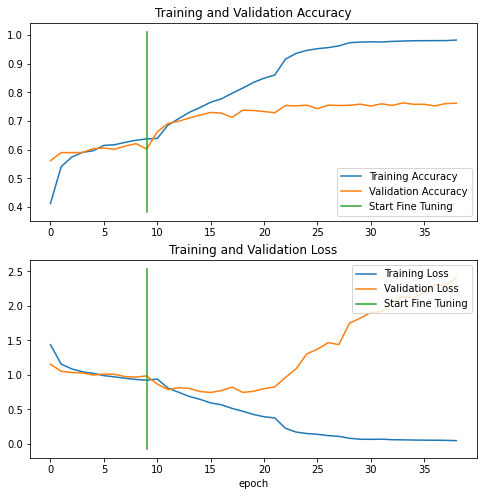

In [104]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_model4, label='Training Accuracy')
plt.plot(val_acc_model4, label='Validation Accuracy')
#plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_model4, label='Training Loss')
plt.plot(val_loss_model4, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **5.4.3 Fine-tuned VGGFace Model: Evaluate on Test Set**

In [105]:
best_vggface_model = tf.keras.models.load_model("/content/drive/MyDrive/saved_models/model_4/model4_vggface_finetuned_bestmodel.hdf5")


In [106]:
loss, accuracy = best_vggface_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

183/183 [==============================] - 20s 101ms/step - loss: 2.3113 - accuracy: 0.7494
Test accuracy : 0.7494000792503357


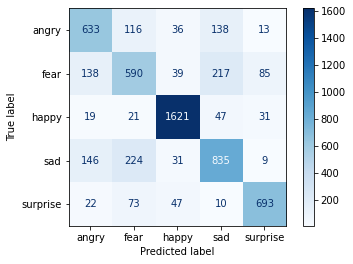

In [107]:
# evaluating test dataset

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = best_vggface_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm_test = confusion_matrix(predicted_labels,correct_labels)

labels = ['angry', 'fear', 'happy', 'sad', 'surprise']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [108]:
print(classification_report(correct_labels, predicted_labels,target_names=labels))

              precision    recall  f1-score   support

       angry       0.68      0.66      0.67       958
        fear       0.55      0.58      0.56      1024
       happy       0.93      0.91      0.92      1774
         sad       0.67      0.67      0.67      1247
    surprise       0.82      0.83      0.83       831

    accuracy                           0.75      5834
   macro avg       0.73      0.73      0.73      5834
weighted avg       0.75      0.75      0.75      5834



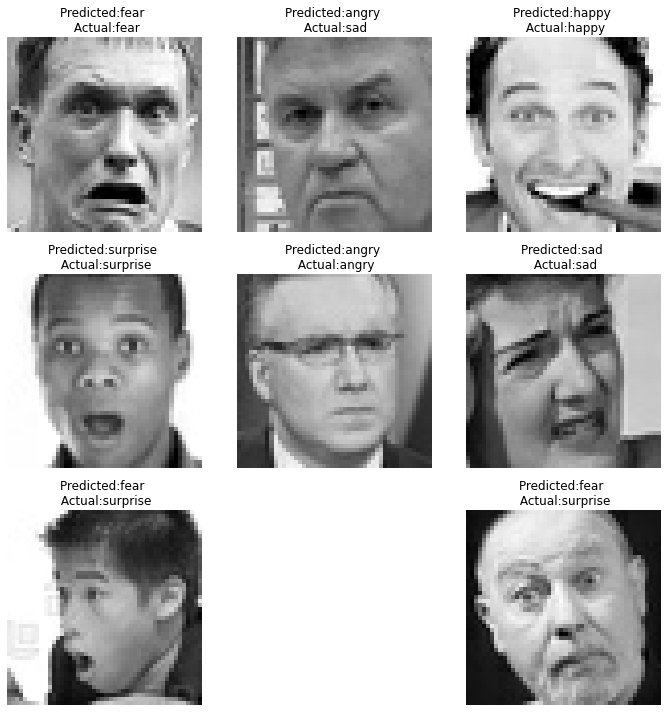

In [109]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = best_vggface_model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("Predicted:{} \n Actual:{}".format(class_names[predictions[i]],class_names[label_batch[i]]))
  plt.axis("off")
  plt.tight_layout()

## Conclusion

As shown in the table below, transfer learning on **VGGFace model** with finetuning applied across all layers produced the best test accuracy score:

| Model | Train Accuracy | Val Accuracy | Delta | Test Accuracy | Evaluation|
| :-: | :-: | :-: | :-:|:-:|:-:|
| VGGFace Model (Finetuned all layers) |0.9786| 0.7629|(0.2157)| 0.7494| 1st|
| MobileNetV2 Model (Finetuned all layers) |0.8247| 0.6857|(0.1390)| 0.6823| 2nd|
| VGG16 Model (Finetuned all layers) |0.9971| 0.6930|(0.3041)| 0.6808| 3rd|
| ResNet50 Model (Finetuned all layers) |0.9219| 0.6492|(0.2727)| 0.6530| 4th|
| Baseline - Custom CNN Model | 0.5796| 0.5792|(0.0004)| 0.5817| Baseline|

However, in terms of speed of training, it is observed that **VGGFace model took the longest time** (~ 250s per epoch) as compared to the other models: VGG16 (~ 110s per epoch), MobileNetV2 (~ 140s per epoch) and ResNet50 (~30s per epoch). 